In [1]:
!pip install pymorphy2[fast]

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pymorphy2
from tqdm.notebook import tqdm
import random
nltk.download('punkt')
nltk.download('stopwords')

import torchtext
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from IPython.display import clear_output
torch.manual_seed(42)
MAX_LEN=256

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 10.0 MB/s 
     |████████████████████████████████| 371 kB 39.8 MB/s 
  Created wheel for DAWG: filename=DAWG-0.8.0-cp37-cp37m-linux_x86_64.whl size=868005 sha256=4eca75ed776398be3a90b5bef1bd907c26f3321162a0cf1df95c1cb94a74501c
  Stored in directory: /root/.cache/pip/wheels/85/51/a4/2de41ff197786537075027c27b479a38da92f50abc86634445
Successfully built DAWG
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Подготовка данных



In [2]:
!cp drive/MyDrive/text_emotion/data/data.json data.json

In [3]:
data = pd.read_json("data.json")
data = data.drop(labels=["id"], axis=1)
print(set(data["sentiment"]))
labels = {
    "negative": 0,
    "positive": 1,
    "neutral": 2
}
for i in labels.keys():
  print(i + " :" + str(sum(data.sentiment==i)))
  data.loc[data.sentiment==i, "sentiment"] = labels[i]
#print(sum(data["sentiment"]))
print(set(data.sentiment))
#data.head(5)

{'positive', 'neutral', 'negative'}
negative :1434
positive :2795
neutral :4034
{0, 1, 2}


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8263 entries, 0 to 8262
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8263 non-null   object
 1   sentiment  8263 non-null   object
dtypes: object(2)
memory usage: 129.2+ KB


In [5]:
text_data_ = np.array(data["text"])
label_data_ = np.array(data["sentiment"])

text_data = []
label_data = []

for (text, lab) in zip(text_data_, label_data_):
  if (len(list(text.split()))) < MAX_LEN:
    text_data.append(text)
    label_data.append(lab)

In [6]:
print(label_data.count(0))
print(label_data.count(1))
print(label_data.count(2))

675
1382
1817


In [7]:
def preproc(s, morph):
  words = nltk.word_tokenize(s, language="russian")
  new_words= [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
  return new_words

In [8]:
morph = pymorphy2.MorphAnalyzer()
for i in tqdm(range(len(text_data))):
  text_data[i] = preproc(text_data[i], morph)

  0%|          | 0/3874 [00:00<?, ?it/s]

In [11]:
stats = Counter()
for sents in text_data:
  for sent in sents:
      stats.update(sent.split())

tokens = dict(stats)
print(len(tokens))

20678


In [12]:
tok2idx = {"[UNK]": 0, "[SOS]": 1, "[EOS]": 2, "[PAD]": 3}
i = 4
X = 20
for tok in tokens:
  if tokens[tok] <= X:
    continue
  tok2idx[tok] = i
  i += 1

print(len(tok2idx))

3084


In [13]:
def encode_t(token):
  if token in tok2idx.keys():
    return tok2idx[token]
  return 0 #UNKNOWN

def encode(sent, sent_len):
  sent = ['[SOS]'] + sent
  sent = sent[0:sent_len-1]
  sent = sent + ['[EOS]']
  while (len(sent) < sent_len):
    sent = sent + ['[PAD]']
  idx = [encode_t(word) for word in sent]
  return idx

In [14]:
dataset = {'text': [], 'label': []}
for text, lab in tqdm(zip(text_data, label_data)):
  dataset['label'].append(lab)
  dataset['text'].append([encode(text, MAX_LEN)][0])

0it [00:00, ?it/s]

In [15]:
class myDataLoader():
  def __init__(self, data, batch_size, device='cpu'):
    self.device = device
    self.data = data
    self.batch_size = batch_size

  def __iter__(self):
    self._ids = [i for i in range(len(self.data['label']))]
    random.shuffle(self._ids)
    return self

  def __next__(self):
    if len(self._ids) >= self.batch_size:
      lab = [self.data['label'][i] for i in self._ids[:self.batch_size]]
      text = [self.data['text'][i] for i in self._ids[:self.batch_size]]
      del self._ids[:self.batch_size]
      return (torch.tensor(text).to(self.device), torch.tensor(lab).to(dtype=torch.long).to(self.device))
    else:
      raise StopIteration("1")

In [16]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                      dropout=dropout) 
        
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, text, text_lengths=MAX_LEN):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text).permute(1, 0, 2)
        
        #embedded = [sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, [text_lengths] * 32)
        
        # cell arg for LSTM, remove for GRU
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  
        
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))

        return self.fc(hidden)

In [18]:
vocab_size = len(tok2idx)
emb_dim = 100
hidden_dim = 256
output_dim = 3
n_layers = 2
bidirectional = True
dropout = 0.45
PAD_IDX = 3
patience=3
device = "cuda"

In [19]:
model = RNN(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)
model = model.to(device)

In [20]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
max_epochs = 1

In [21]:
def train(network, loader, loss_func, optimizer, tf=0.3, train_history=None, valid_history=None):

  network.train()

  epoch_loss = 0

  history = []
  num = 0
  
  for (text, lab) in tqdm(loader):
      
    optimizer.zero_grad()
    pred = network(text)
    loss = loss_func(pred, lab)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().item()

    history.append(loss.cpu().item())

    if (num+1)%10==0:
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

      clear_output(True)
      ax[0].plot(history, label='train loss')
      ax[0].set_xlabel('Batch')
      ax[0].set_title('Train loss')
      if train_history is not None:
          ax[1].plot(train_history, label='general train history')
          ax[1].set_xlabel('Epoch')
      if valid_history is not None:
          ax[1].plot(valid_history, label='general valid history')
      plt.legend()
      
      plt.show()

    num += 1
    

  return epoch_loss / num


def eval(network, loader, loss_func):

  network.eval()

  epoch_loss = 0

  history = []
  num = 0

  for (text, lab) in loader:
    
    pred = model(text)
    epoch_loss += loss_func(pred, lab).cpu().item()

    num += 1

  return epoch_loss / num

In [22]:
L = len(dataset["label"])
idx = [i for i in range(L)]
train_id, val_id = train_test_split(idx, test_size = 0.2)

train_data = {'text': [], 'label': []}
val_data = {'text': [], 'label': []}

for num, (text, lab) in enumerate(zip(dataset['text'], dataset['label'])):
  if num in val_id:
    val_data['label'].append(lab)
    val_data['text'].append(text)
  else:
    train_data['text'].append(text)
    train_data['label'].append(lab)

In [23]:
train_loader = myDataLoader(train_data, 32, device)
val_loader = myDataLoader(val_data, 32, device)

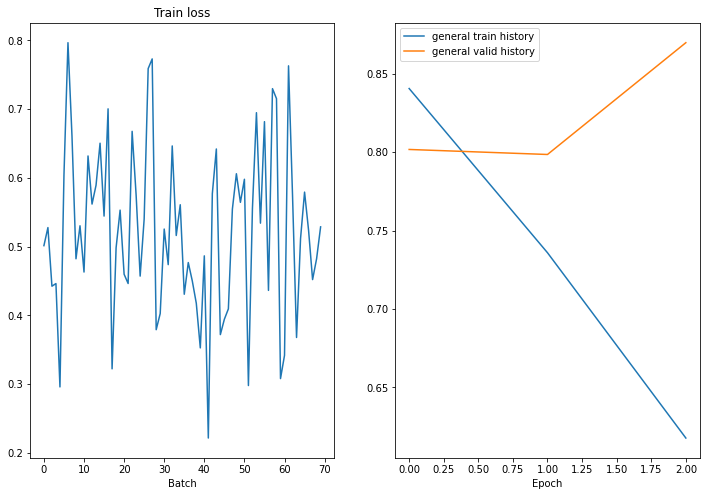

KeyboardInterrupt: ignored

In [27]:
train_history = []
valid_history = []
best = np.inf

EPOCHS = 6

for i in range(EPOCHS):

  train_loss = train(model, train_loader, loss_func, opt, 0.3, train_history, valid_history)
  valid_loss = eval(model, val_loader, loss_func)

  if train_loss < best:
    best = train_loss
    torch.save(model.state_dict(), "model.pt")

  train_history.append(train_loss)
  valid_history.append(valid_loss)

  print(f'EPOCH: {1} | train loss: {train_loss} | valid loss: {valid_loss}')
  print(20 * '-')

In [34]:
model.load_state_dict(torch.load("model.pt"))
epoch_loss = 0
for (text, lab) in tqdm(val_loader):
  pred = model(text)
  pred = pred.argmax(dim = 1)
  epoch_loss += torch.sum(pred == lab).cpu()
print(epoch_loss / len(val_data["label"]))

0it [00:00, ?it/s]

0.78


In [37]:
import json
open("tok2idx.json", "w").write(json.dumps(tok2idx))

169754

In [38]:
with open("tok2idx.json", "r") as my_file:
    new = my_file.read()